# Preliminaries

In [1]:
#@title Install libraries
%%capture
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install vincenty

In [ ]:
#@title Mount google drive
from google.colab import drive
drive.mount('/gdrive')

import os
import sys

os.chdir(r'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB')
if "." not in sys.path:
  sys.path.append(".")

In [3]:
#@title import libraries
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import time
import copy

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import catboost
import tensorflow as tf

# My helpers
import helpers.run_model as run_model
import helpers.tune_model as tune_model
import helpers.data_prep as data_prep

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set(color_codes=True)

# Reimport after change
import importlib
# importlib.reload(run_model)  

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn import ensemble
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, r2_score

In [5]:
from helpers import run_model

In [6]:
import importlib
importlib.reload(run_model)

<module 'helpers.run_model' from '/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB/helpers/run_model.py'>

# Dataset

In [7]:
DATA_DIR = 'data/'
SEED_FOR_SPLIT = 0  # random_state for split

In [8]:
x_train_encoded = pd.read_csv(DATA_DIR + 'prepared/x_train_1hot.csv.zip', compression='zip')
y_train = pd.read_csv(DATA_DIR + 'y_train.csv')
x_test_encoded = pd.read_csv(DATA_DIR + 'prepared/x_test_1hot.csv.zip', compression='zip')

In [9]:
# convert all to float (required by statsmodel)
x_train_encoded = x_train_encoded.astype(float)
x_test_encoded = x_test_encoded.astype(float)

In [10]:
# -- split
x_train_sp, x_test_sp, y_train_sp, y_test_sp = train_test_split(
    x_train_encoded,
    y_train, 
    test_size=0.33, 
    random_state=SEED_FOR_SPLIT
    )
print('Split dataset shapes', x_train_sp.shape, x_test_sp.shape)

Split dataset shapes (146955, 892) (72382, 892)


In [11]:
Y_NAMES = list(y_train.columns[1:3].values)
ENCODED_VAR_NAMES = x_train_encoded.columns[[c.startswith('H_') for c in x_train_sp.columns]]
NOT_ENCODED_VAR_NAMES = x_train_encoded.columns[[c not in ENCODED_VAR_NAMES for c in x_train_sp.columns]]

In [12]:
x_train_sp.shape, y_train_sp.shape, x_test_sp.shape, y_test_sp.shape

((146955, 892), (146955, 4), (72382, 892), (72382, 4))

In [13]:
x_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219337 entries, 0 to 219336
Columns: 892 entries, intervention on public roads to H_intervention_place_398
dtypes: float64(892)
memory usage: 1.5 GB


In [14]:
#[c for c in x_train_sp.columns if c.startswith('H_')]

# Remove highly correlated variables

OLS revealed poor conditioned design matrix (cond. No > 2.54e+23).
It also warned:
[2] The smallest eigenvalue is 9.27e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.<br>

Colinear variables must be removed.<br>
BTW, OLS often ran out of memory (> 12gb).


In [15]:
%%time
corr_mat = x_train_encoded.corr(method='pearson')

CPU times: user 6min 9s, sys: 0 ns, total: 6min 9s
Wall time: 6min 9s


In [16]:
corr_mat.shape

(892, 892)

In [17]:
threhold = 0.8
found = {'i': [], 'j': [], 
         'vi': [], 'vj': [],
         'pearson': [] }
for i in range(corr_mat.shape[0]):
  for j in range(corr_mat.shape[1]):
    if j < i :
      if corr_mat.iloc[i, j] > threhold:
        found['i'].append(i)
        found['vi'].append(corr_mat.columns[i])
        found['j'].append(j)
        found['vj'].append(corr_mat.columns[j])
        found['pearson'].append(corr_mat.iloc[i, j])
        
found_df = pd.DataFrame(found)
found_df.sort_values('pearson', ascending=False)

,i,j,vi,vj,pearson
78,606,7,H_status preceding selection_Rentré,departed from its rescue center,1.000000
77,604,495,H_rescue center_266324,H_vehicule_ownrer_BALA,1.000000
70,494,443,H_vehicule_ownrer_APP,H_vehicule_type_CMO,1.000000
37,33,31,waypoint4_lat,waypoint3_lat,1.000000
17,28,1,waypoint2_lon,longitude intervention,0.999999
...,...,...,...,...,...
65,49,46,GPS_Tracks_80pc_kmh,GPS_Tracks_distance_km,0.856244
71,498,487,H_vehicule_ownrer_BSPP,H_vehicule_type_VSAV,0.832849
73,506,462,H_vehicule_ownrer_Missing,H_vehicule_type_PSE,0.827168
67,152,56,H_alert reason_2524,H_alert reason category_7,0.808639


In [18]:
found_df.shape[0]

79

In [19]:
found_df[found_df.pearson > 0.9].shape[0]

59

In [20]:
# Remove vars
set(found['i']).intersection(set(found['j']))

{8, 9, 16, 24, 25, 26, 27, 30, 31, 32, 36, 37, 38, 39, 40, 41, 44, 47}

In [21]:
to_rm = set()
to_keep = set()
for ix, row in found_df.sort_values('pearson', ascending=False).iterrows():
  if not row.i in to_keep:
    to_rm.add(row.i)
  if not row.j in to_rm:
    to_keep.add(row.j)

len(to_rm), len(to_keep)

(33, 30)

In [22]:
cols_ix = [i for i in range(x_train_sp.shape[1]) if i not in to_rm]
x_train_sp = x_train_sp.iloc[:, cols_ix]
x_test_sp = x_test_sp.iloc[:, cols_ix]
x_train_sp.shape, x_test_sp.shape

((146955, 859), (72382, 859))

# Baseline model - OLS


## Using statsmodels

In [23]:
# Note: sm.OLS can't support sparse matrix
import statsmodels.api as sm
# https://www.statsmodels.org/stable/index.html

In [24]:
#@title Y0 / statsmodels
%%time
y_name = Y_NAMES[0]
try: ALL_RESULTS
except NameError: ALL_RESULTS = []

ols = sm.OLS(endog=y_train_sp[y_name], 
             exog=x_train_sp)
_, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name='statsmodel ols',
            model=ols,
            x_train=x_train_sp, 
            y_train=y_train_sp[y_name],
            x_test=x_test_sp, 
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )

CPU times: user 2min 44s, sys: 18.2 s, total: 3min 2s
Wall time: 52.4 s


In [25]:
#@title check free memory
from psutil import virtual_memory
ram_gb = virtual_memory().free / 1e9
print('Free RAM: {:.1f} gigabytes \n'.format(ram_gb))

import sys
m = ALL_RESULTS[-1].model
print(sys.getsizeof(ols))

Free RAM: 11.4 gigabytes 

56


In [26]:
%pwd

'/gdrive/My Drive/Colab Notebooks/GITHUB/X_PFB'

In [27]:
# Save model (to prevent from out of memory later)
import datetime

SAVE_MODEL_DIR = "models/"
if not os.path.exists('models'):
  os.mkdir("models")
i=0
MODEL_FILE = f"sm_ols.15a.{datetime.datetime.now():%Y%m%d_%H%M}.Y{i}.model"

m = ALL_RESULTS[-1].model
m.save(SAVE_MODEL_DIR + MODEL_FILE)

In [28]:
ols_res = ALL_RESULTS[-1].model
ols_res_summary = ols_res.summary()
print(ols_res_summary)

                                OLS Regression Results                               
Dep. Variable:     delta selection-departure   R-squared:                       0.188
Model:                                   OLS   Adj. R-squared:                  0.183
Method:                        Least Squares   F-statistic:                     40.51
Date:                       Thu, 10 Sep 2020   Prob (F-statistic):               0.00
Time:                               18:42:16   Log-Likelihood:            -8.3290e+05
No. Observations:                     146955   AIC:                         1.667e+06
Df Residuals:                         146120   BIC:                         1.676e+06
Df Model:                                834                                         
Covariance Type:                   nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------

In [29]:
#@title Y1 / statsmodels
y_name = Y_NAMES[1]
try: ALL_RESULTS
except NameError: ALL_RESULTS = []

ols = sm.OLS(endog=y_train_sp[y_name], 
             exog=x_train_sp)
_, ALL_RESULTS_DF = run_model.run_new_model(
            y_name=y_name,
            name='statsmodel ols',
            model=ols,
            x_train=x_train_sp, 
            y_train=y_train_sp[y_name],
            x_test=x_test_sp, 
            y_test=y_test_sp[y_name],
            results=ALL_RESULTS
            )

**Interpreting the summary**<br>
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01

- R2 : 0.402 : 40% of variance are explained by the predictors.
- Adjusted R2: 0.309 () Takes in account the number of predictors. It increases only when the predictors improves the model more than by chance.
- Prob(F-statistic): 0 => the linear model is significant in overall
- 

In [30]:
print(ALL_RESULTS[-1].model.summary())

                                 OLS Regression Results                                 
Dep. Variable:     delta departure-presentation   R-squared:                       0.402
Model:                                      OLS   Adj. R-squared:                  0.399
Method:                           Least Squares   F-statistic:                     118.0
Date:                          Thu, 10 Sep 2020   Prob (F-statistic):               0.00
Time:                                  18:43:31   Log-Likelihood:            -9.6652e+05
No. Observations:                        146955   AIC:                         1.935e+06
Df Residuals:                            146120   BIC:                         1.943e+06
Df Model:                                   834                                         
Covariance Type:                      nonrobust                                         
                                                                    coef    std err          t      P>|t|     

https://www.accelebrate.com/blog/interpreting-results-from-linear-regression-is-the-data-appropriate <br>
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01<br>

The last section is about the normality of residuals.<br>
- **High Omnibus => the errors are very skew compared to normal curve**<br>
- **Prob (Omnibus)** = probability that the residuals are normally distributed = 0<br>
- **Kurtosis** = Positive values means more outliers than the normal.<br>
- **Skew** = High positive means tail is heavy on the right side<br>
- **Durbin-Watson** = tests for homoscedasticity = We hope to have a value between 1 and 2. In this case, the data is close, but within limits.<br>
- Prob(Jarque-Bera): It i in line with the Omnibus test. It is also performed for the distribution analysis of the regression errors. It is supposed to agree with the results of Omnibus test. A large value of JB test indicates that the errors are not normally distributed.

- **Cond. No. = Huge (normally <= 30) => there might be multicollinearity => very unstable model**<br>

In [31]:
ALL_RESULTS_DF

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,statsmodel ols,delta selection-departure,5511.469051,0.187788,5511.469051,0.088109,33.307910,<statsmodels.regression.linear_model.Regressio...
1,statsmodel ols,delta departure-presentation,36243.505351,0.402453,36243.505351,0.345761,28.599401,<statsmodels.regression.linear_model.Regressio...


# Y1 model analysis

In [32]:
#@title Residuals on test and R2
models = [ALL_RESULTS[0].model, ALL_RESULTS[-1].model]
r2s, res_dfs = run_model.r2_score_all(
    models=models,
    x_test_sp_list=[x_test_sp, x_test_sp],
    y_test_sp=y_test_sp)

R2 of delta selection-departure: 0.08810872168911155
R2 of delta departure-presentation: 0.34576146447715495
R2 of delta selection-presentation: 0.37570840908323555
Mean R2 (Y0, Y1): 0.21693509308313325


In [33]:
def display_resid_distrib(res, y_lim, res_lim):
  plt.figure(figsize=(18,13))

  ax = plt.subplot(321)
  z = res.y_true.sort_values().iloc[:-100] # Skip extreme values
  sns.distplot(z, ax=ax)
  ax.set_xlim(*y_lim)

  ax = plt.subplot(322)
  sns.distplot(res.resid.sort_values().iloc[100:], ax=ax) # Skip the 100 lowest negative resid
  ax.set_xlim(*res_lim)

  ax = plt.subplot(323)
  z = res.y_pred.sort_values().iloc[:-100] # Skip extreme values
  sns.distplot(z, ax=ax)
  ax.set_xlim(*y_lim)

  ax = plt.subplot(324)
  sns.distplot(res.resid_standardized.sort_values().iloc[100:], ax=ax) # Skip the 100 lowest resid
  ax.set_xlim(-3, 3)

  ax = plt.subplot(325)
  stats.probplot(res.sort_values('resid')[100:].resid,
                 plot=ax)

  plt.tight_layout()

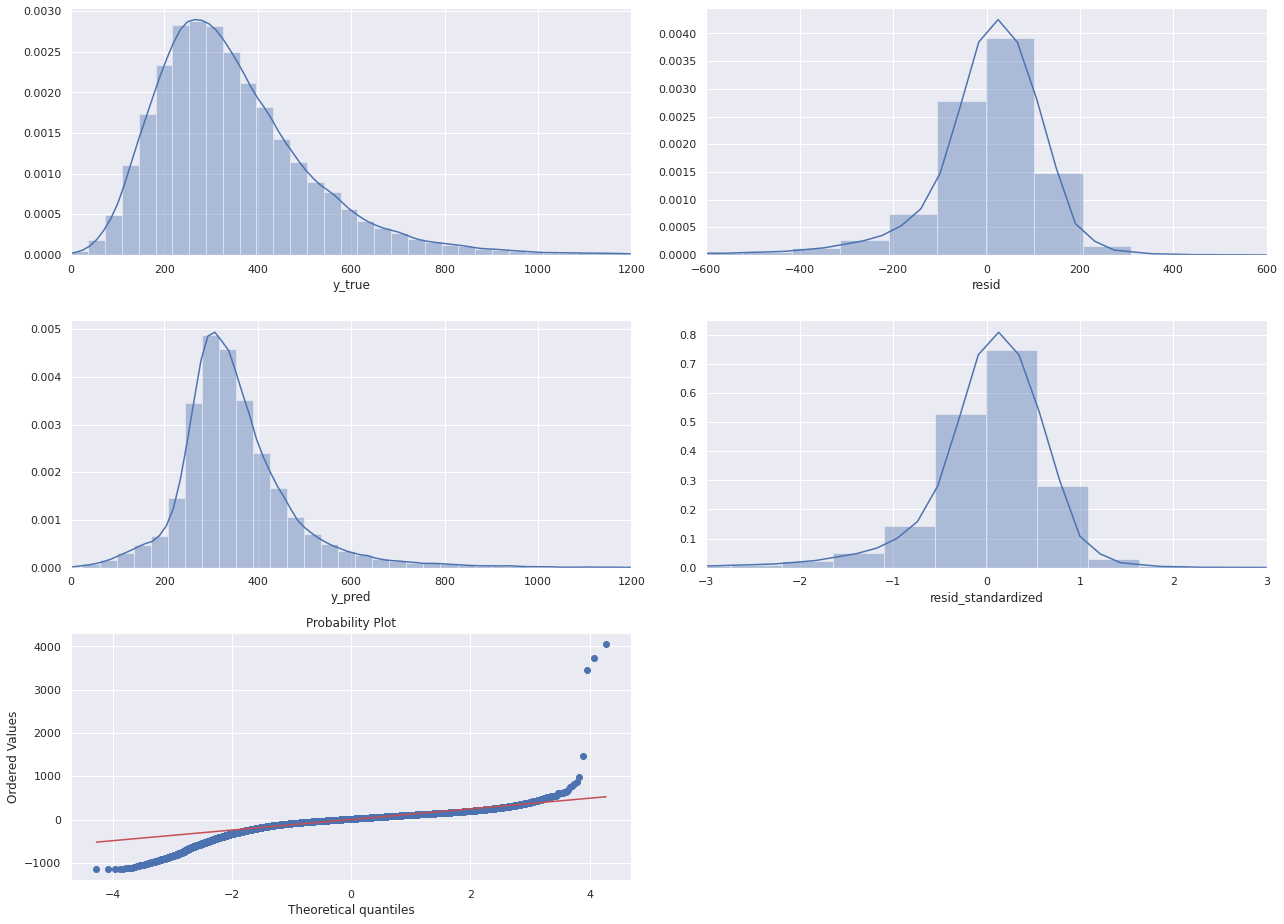

In [34]:
display_resid_distrib(res=res_dfs[1], y_lim=(0,1200), res_lim=(-600, 600))

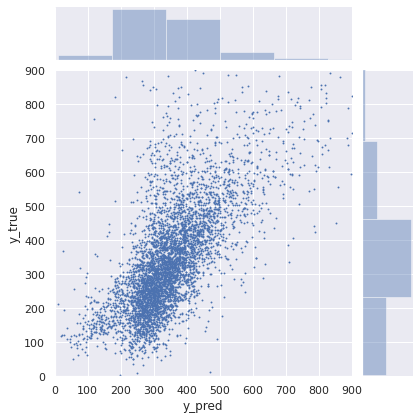

In [36]:
# Y0 - prediction vs actual
sns.jointplot(x='y_pred', y='y_true', 
              data=res_dfs[0].sample(n=5000), 
              s=0.8, 
              xlim=(0,900), ylim=(0, 900))

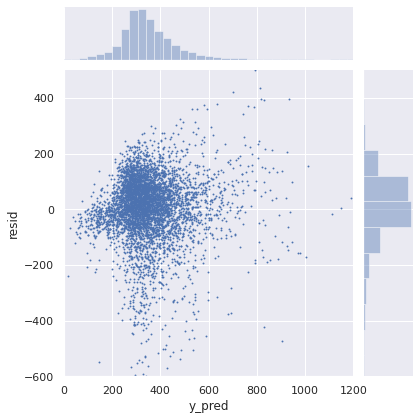

In [37]:
# Y0 - prediction vs actual
sns.jointplot(x='y_pred', y='resid', data=res_dfs[1].sample(n=5000), 
              s=0.8, 
              xlim=(0,1200), ylim=(-600, 500))

# Remove extreme values of Y

In [ ]:
for y_name in Y_NAMES:
    # Limits to those with selection-departure < quantile 
    y_max = y_train_sp[y_name].quantile(0.99)
    ix_mask = y_train_sp[y_name] < y_max
    
    pipe = Pipeline(steps=[('LinearRegression', linear_model.LinearRegression()),])
    res = run_model(model=pipe, 
                    x_train=x_train_sp[ix_mask], y_train=y_train_sp[ix_mask][y_name], 
                    x_test=x_test_sp,   y_true=y_test_sp[y_name]
                   )
    new_entry = Result(name='LinearRegression_YQuantile99', y_name=y_name, **res)
    # print(new_entry)
    ALL_RESULTS.append(new_entry)


In [ ]:
pd.DataFrame([r._to_list() for r in ALL_RESULTS], columns=ALL_RESULTS[0]._get_att_names())

,name,y_name,mse_train,R2_train,mse_test,R2_test,fit_time,model
0,LinearRegression,delta selection-departure,7894.402088,0.163475,7894.402088,0.052958,7.425387,"LinearRegression(copy_X=True, fit_intercept=Tr..."
1,LinearRegression,delta departure-presentation,35460.740385,0.314303,35460.740385,0.262584,7.113942,"LinearRegression(copy_X=True, fit_intercept=Tr..."
2,LinearRegression_YQuantile99,delta selection-departure,7866.021752,0.163676,7866.021752,0.056363,6.120783,"(LinearRegression(copy_X=True, fit_intercept=T..."
3,LinearRegression_YQuantile99,delta departure-presentation,35679.278760,0.375905,35679.278760,0.258039,6.680392,"(LinearRegression(copy_X=True, fit_intercept=T..."
